In [1]:
import numpy as np
import os, sys, re, glob
from dolfin import *
from __future__ import print_function
from fenics import *
import pickle
from numpy.random import rand
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from numpy.linalg import norm
font = {'family' : 'Times New Roman',
        'weight' : 'regular',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rc('axes', linewidth=2)
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['xtick.major.size'] = 20                                                                                                                                     
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
    
#c_0 = load_obj('initial_c0.pkl')

[alamgir:19631] shmem: mmap: an error occurred while determining whether or not /var/folders/h6/y0001fs148g09jbjqhg9zvg80000gn/T//ompi.alamgir.501/jf.0/994902016/sm_segment.alamgir.501.3b4d0000.0 could be created.


In [2]:
# Functions
def BV_rates(ko, eta=0.0, A=1.0, alpha=0.5):
    kbT = 0.0259
    kred = A*ko*np.exp(-(alpha*(eta))/kbT)
    kox = A*ko*np.exp(((1-alpha)*(eta))/kbT)
    return kox, kred

def get_current_2D(func, mesh, a_s = 1e-7):
    # func: _c_3 in our case (Ru3+), a_s: 100nm pippete radius                                                                          
    F = 96485.332
    r = np.linspace(0,a_s,100)
    Jo_list = []
    vec = project(func.dx(2), FunctionSpace(mesh, P1))
    for j in range(len(r)):
        point = np.array([r[j], 0.0])
        x = np.array(point)
        x_point = Point(x)
        Jo = -D_o*vec(x_point)
        Jo_list.append(Jo)
    i = 2*np.pi*F*np.trapz(Jo_list*r, x=r)
    return i

def get_current_3D(func, mesh, a_s = 1e-7):
    # func: _c_3 in our case (Ru3+), a_s: 100nm pippete radius                                                                          
    F = 96485.332
    r_list = np.linspace(0,a_s,100)
    th_list = np.linspace(0,2*np.pi,100)
    Jo_mat = np.zeros((len(r_list), len(th_list)))
    vec = project(func.dx(2), FunctionSpace(mesh, P1))
    vec.set_allow_extrapolation(True)
    
    def xy_coord(r, th):
        return [r*np.cos(th), r*np.sin(th)]
    
    for j in range(len(r_list)):
        for k in range(len(th_list)):
            xy = xy_coord(r_list[j], th_list[k])
            point = np.array([xy[0], xy[1], 0.0])
            xy_point = Point(point)
            Jo = -D_o*vec(xy_point)
            Jo_mat[j, k] = Jo
    
    y = np.trapz(Jo_mat, x=th_list, axis=1)*r_list
    i = F*np.trapz(y, x=r_list)
    return i

def check_sol1():
    point = [1e-7, 0.7e-7]
    x = np.array(point)
    x_point = Point(*x) 
    P1 = FiniteElement('P', triangle, 1)
    vec1 = project(_c_4.dx(0), FunctionSpace(mesh, P1))
    vec2 = project(_c_3.dx(0), FunctionSpace(mesh, P1))
    vec3 = project(_c_2.dx(0), FunctionSpace(mesh, P1))
    vec4 = project(_c_1.dx(0), FunctionSpace(mesh, P1))
    print(norm(np.array([vec1(x_point), vec2(x_point), vec3(x_point), vec4(x_point)])))
    
def check_sol2():
    point = [0.6e-7, 0]
    x = np.array(point)
    x_point = Point(*x) 
    P1 = FiniteElement('P', triangle, 1)
    vec = project(_c_3.dx(1)+_c_4.dx(1), FunctionSpace(mesh, P1))
    print(vec(x_point))

def check_sol3():
    point = [0.6e-7, 0]
    x = np.array(point)
    x_point = Point(*x) 
    P1 = FiniteElement('P', triangle, 1)
    vec1 = project(_c_2.dx(1), FunctionSpace(mesh, P1))
    vec2 = project(_c_1.dx(1), FunctionSpace(mesh, P1))
    print(norm(np.array([vec1(x_point), vec2(x_point)])))
    
def save_sol(fname, u, mesh):
    # u is a function                                                                                                                                                          
    output_file = HDF5File(mesh.mpi_comm(), fname+".h5", "w")
    output_file.write(u, "solution")
    output_file.close()
    
def load_sol(fname, U, mesh):
    # U is a function                                                                                                                                                          
    input_file = HDF5File(mesh.mpi_comm(), fname+".h5", "r")
    input_file.read(U, "solution")
    input_file.close()
    return U

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

## Load and Visualize Mesh

In [56]:
loc = ''
mesh = Mesh(loc+'mesh3D.xml');
#cd=MeshFunction('size_t',mesh,loc+'mesh_physical_region.xml')
#fd=MeshFunction('size_t',mesh,loc+'mesh_facet_region.xml')

In [4]:
from vedo.dolfin import plot
mesh = Mesh('mesh3D.xml');
# plt = plot(mesh, 
#            mode="displaced mesh",
#            lighting='plastic',
#            axes=1,
#            viewup='z',
#            interactive=0)
bmesh = BoundaryMesh(mesh, "exterior", True)
bmesh

# PNP Main Solve

## Constants

In [48]:
## Constants Radial
z_1, z_2, z_3, z_4 = 1, -1, 3, 2 # Charge numbers K+, Cl-, Ru3+, Ru2+
c_ruhex = 2 #mM
c_KCl = 100 #mM
# Note 1mM = 1mol/m3 (SI units)
eps = 80
eps0 = 8.854187e-12 # Vacuum permittivity F/m
e = 1.60218e-19 # Coulombs 
kbT = 0.0259 # eV, room temp
F = 96485.332 # C/mol
D_o, D_r = 8.43e-10 , 1.19e-9 # Diff constants (m^2/s)
a = (1/kbT)
b = a*(F/(eps*eps0))
#a, b = 1, 10e9
k_o = 0.0001
Eo = -0.25
V_dl = -0.291198576 #V Electrode potential
V_dl = 0.0
d_h = 0.5e-9 #0.5nm Stern layer thickness
Vapp_list = np.linspace(-0.5, -0.1, 9)
Vapp = 0.0
print('Vapp={}, Vdl={}, ko={}'.format(Vapp, V_dl, k_o),'\n')

Vapp=0.0, Vdl=0.0, ko=0.0001 



## Set BCs

In [49]:
## Set Dirichlet BC

# Define Function Space                                                                                                        
P1 = FiniteElement('P', tetrahedron, 1)
element = MixedElement([P1, P1, P1, P1, P1])
V = FunctionSpace(mesh, element)

deg = 1
phi_D = Expression(str(0.0), degree=deg)

def boundary(x, on_boundary):
    return on_boundary

c_a = Expression(str(c_KCl), degree=deg)
c_b = Expression(str(z_1*c_KCl + z_3*c_ruhex), degree=deg)
c_c = Expression(str(c_ruhex), degree=deg)
c_d = Expression(str(0.0), degree=deg)

tol = DOLFIN_EPS
def boundary_5(x, on_boundary):
    return on_boundary and near(x[2], 2e-5, tol)

# phi BCs                                                                                                                               
bc_1= DirichletBC(V.sub(0), phi_D, boundary_5)                                                                                                              

# conc BCs                                                                                                                              
bc_5a= DirichletBC(V.sub(1), c_a, boundary_5)
bc_5b= DirichletBC(V.sub(2), c_b, boundary_5)
bc_5c= DirichletBC(V.sub(3), c_c, boundary_5)
bc_5d= DirichletBC(V.sub(4), c_d, boundary_5)
bcs = [bc_1, bc_5a, bc_5b, bc_5c, bc_5d]


## Define Test Functions
v, q_1, q_2, q_3, q_4 = TestFunctions(V)
sol = Function(V)
dsol = TrialFunction(V)
phi, c_1, c_2, c_3, c_4 = split(sol)

## Different Neumann BC for bottom BC 

# create a mesh function which assigns an unsigned integer (size_t) to each edge                                                        
mf = MeshFunction("size_t", mesh, mesh.topology().dim() - 1) # 3rd argument is dimension of an edge                                                             
mf.set_all(0) # initialize the function to zero                                                                                         
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        tol = DOLFIN_EPS
        return near(x[2], 0.0, tol) and on_boundary # Use x[2] for 3D.

bottomboundary = BottomBoundary() # instantiate it 

# use this bottomboundary object to set values of the mesh function to 1 in the subdomain                                               
bottomboundary.mark(mf, 1)

# define a new measure ds based on this mesh function                                                                                   
ds = Measure("ds", domain=mesh, subdomain_data=mf)
File("mf.pvd").write(mf) # Save mf for Paraview                                                                                        

## Define Weak Form

In [50]:
### Compute solution                                                                                                                    
## Define problem for phi                                                                                                               
n = FacetNormal(mesh)
r = Expression('x[0]', degree=deg)                                                                                   
dphi_1 = Expression('0.0', degree=deg)


## Define problem for conc                                                                                                                                                                                                                 
g_1 = Expression('0.0', degree=deg)
g_2 = Expression('0.0', degree=deg)
g_3 = Expression('0.0', degree=deg)
g_4 = Expression('0.0', degree=deg)

## Set reaction rates
kox, kred = BV_rates(k_o, eta=Vapp)
m1 = -(kred*c_3 - kox*c_4)/D_o # Rate theory input 
m2 = dot(grad(c_4), n)

Func = (inner(grad(phi),grad(v)))*dx() - ((V_dl - phi)/d_h)*v*ds(1) \
    - (F/(eps*eps0))*(z_1*c_1 + z_2*c_2 + z_3*c_3 + z_4*c_4)*v*dx() + dphi_1*v*ds(0) \
    + ((inner(grad(c_1), grad(q_1))) - ((z_1*a)*div(c_1*grad(phi))*q_1))*dx() \
    + ((inner(grad(c_2), grad(q_2))) - ((z_1*a)*div(c_2*grad(phi))*q_2))*dx() \
    + ((inner(grad(c_3), grad(q_3))) - ((z_1*a)*div(c_3*grad(phi))*q_3))*dx() \
    + ((inner(grad(c_4), grad(q_4))) - ((z_1*a)*div(c_4*grad(phi))*q_4))*dx() \
    - g_1*q_1*ds() - g_2*q_2*ds() - g_3*q_3*ds(0) - g_4*q_4*ds(0) \
    - m1*q_3*ds(1) + (D_o/D_r)*m1*q_4*ds(1) \

L = 0

## Solver Settings and Solve

In [51]:
# Solver configs                                                                                                                        
ffc_options = {"optimize": True, "quadrature_degree": 4}

solver_parameters = {"nonlinear_solver": "snes",
                     "snes_solver" : {
                         "report" : True,
                         "error_on_nonconvergence" : False,
                         "line_search" : "bt",
                         "linear_solver" : "bicgstab", # cg, bicgstab, gmres, lu, superlu_dist                                          
                         "preconditioner" : "sor", # sor, amg, hypre_euclid, petsc_amg, ilu, icc                                        
                         #"convergence_criterion": "incremental",                                                                       
                         "absolute_tolerance" : 1E-7,
                         "relative_tolerance" : 1E-6,                                                                                  
                         "maximum_iterations" : 20000,
                         #"relaxation_parameter" : 0.9,                                                                                 
                         "krylov_solver" : {
                             "maximum_iterations" : 20000,
                             #"monitor_convergence" : True,                                                                             
                             "nonzero_initial_guess" : False
                         }}}

J = derivative(Func, sol, dsol)
problem = NonlinearVariationalProblem(Func, sol, bcs, J, form_compiler_parameters=ffc_options)
solver = NonlinearVariationalSolver(problem)
solver.parameters.update(solver_parameters)
solver.solve()

_phi, _c_1, _c_2, _c_3, _c_4 = sol.split()

#plot(mesh)

sol_0 = sol.copy()

# check_sol1()
# check_sol2()
# check_sol3()

curr = get_current_3D(_c_3, mesh, a_s = 1e-7)
print('I = '+str(curr))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  0 SNES Function norm 1.134242831143e+04
  1 SNES Function norm 4.909586935426e-04
  PETSc SNES solver converged in 1 iterations with convergence reason CONVERGED_FNORM_RELATIVE.
I = -5.315675511894001e-13


## Visualize

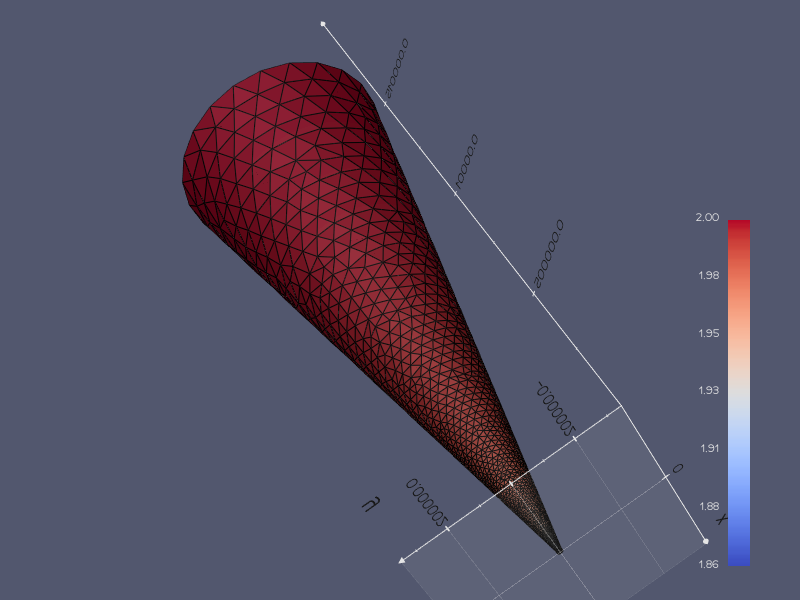

In [55]:
from vedo.dolfin import plot
## Plot solution and mesh
plot(_c_3, 
    #mode="arrows",
    lighting='plastic',
    lw = 0.01,
    axes=1,
    interactive=0,
    viewup=(-1,-1,1),
    zoom=2,
    style=2)

#plt.show()

## Point Evaluations

In [81]:
_c_1(0, 0, 2e-5)

100.00000339580365

In [16]:
point = [0.5e-7, 0.0e-7, 0]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(_c_3.dx(2), FunctionSpace(mesh, P1))
vec(x_point)

2955036.6178543814

In [24]:
point = [0.0e-7, 0.0e-7, 0]
x = np.array(point)
x_point = Point(*x) 
P1 = FiniteElement('P', tetrahedron, 1)
vec = project(_phi.dx(2), FunctionSpace(mesh, P1))
-vec(x_point)

2102033154.399569

In [25]:
(V_dl - _phi(0.0e-7, 0.0e-7, 0))/d_h

2106448598.1148617

In [23]:
_phi(0.5e-7, 0e-5, 0)

-1.3475494781630546

# Mesh Dimensions

In [9]:
bmesh = BoundaryMesh(mesh, "exterior", True)
arr = bmesh.coordinates()
bot_coords = np.array([arr[i] for i in range(len(arr)) if np.allclose(arr[i,2],0)])
a_s = np.max(norm(bot_coords[:,:2], axis=1))
a_s

1.0000000000000001e-07

In [14]:
z = np.max(arr[:,2])
top_coords = np.array([arr[i] for i in range(len(arr)) if np.allclose(arr[i,2],z)])
a_t = np.max(norm(top_coords[:,:2], axis=1))
z

2.000000000000001e-05

# Solver parameters

In [ ]:
ffc_options = {"optimize": True, "quadrature_degree": 8}


newton_solver_parameters = {"nonlinear_solver": "newton",
							"newton_solver" : {
									"linear_solver" : "lu",
									"convergence_criterion": "incremental",
									"absolute_tolerance" : 1E-6,
									"relative_tolerance" : 1E-6,
									"maximum_iterations" : 50,
									"relaxation_parameter" : 1.0 }}

problem1 = NonlinearVariationalProblem(F1, c, bcs, J1, form_compiler_parameters=ffc_options)
problem1G = NonlinearVariationalProblem(F1_G, c_G, bcs1, J1_G, form_compiler_parameters=ffc_options)
solver1  = NonlinearVariationalSolver(problem1)
solver1.parameters.update(newton_solver_parameters)